In [1]:
import numpy as np 
import networkx as nx
from copy import copy
from scipy.linalg import svd, sqrtm

from itertools import combinations 
from tqdm import tqdm 
from matplotlib import pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

from scipy.fft import dct
import random

In [2]:
class GrassmanGraph:
    def __init__(
            self, 
            N, 
            D, 
            K = None, 
            K_max = None,
            basis = None, 
            SNR = None,
            seed = 42,
            snaps = 1000,
            basis_mode = 'Canonic'
        ):
        
        assert N >= D
        
        self.N = N
        self.D = D
        self.K = K
        self.K_max = K_max
        
        self.snaps = snaps
        self.SNR = SNR
        
        self.basis = basis
        self.basis_mode = basis_mode
        
        self.seed = seed

        self.setup()

    def setup(self):

        self.subSpaceAssignment()
        self.pairwise_distances()
        self.signals_generation()
        self.sorted_connections()
        self.graphs_()

    def k_SVD(self, A):
        U, S, Vt = np.linalg.svd(A, full_matrices=True)
        
        U_k = U[:, :self.K]  
        S_k = np.diag(S[:self.K])  
        Vt_k = Vt[:self.K, :]  

        A_k = U_k @ S_k @ Vt_k

        return A_k[0:self.K,0:self.K]
    
    def subSpaceAssignment(self):
        
        np.random.seed(self.seed)

        # Shared sparsity level
        if self.K is not None:
            return {n: np.random.choice(self.D, self.K, replace = False) for n in range(self.N)}
        else:

            # Random sparsity level
            if self.K_max is not None:
                return {n: np.random.choice(self.D, np.random.randint(1, self.K_max, 1), replace = False) for n in range(self.N)}
            else:
                return {n: np.random.choice(self.D, np.random.randint(1, self.D, 1), replace = False) for n in range(self.N)}

    def GrassmanDistance(
            self,
            U_A,
            U_B
        ):
        
        k, l = U_A.shape[1], U_B.shape[1]
        
        _, S, _ = np.linalg.svd(U_A.T @ U_B)
        S = np.clip(S, -1.0, 1.0)
        
        return np.linalg.norm(np.arccos(S[0:min([k,l])]))

    def pairwise_distances(self):
        self.SSA = self.subSpaceAssignment()

        if self.basis_mode == 'Canonic':
            self.basis = np.eye(self.D)
        else:
            self.basis = self.basis

        self.pair_wise_subspaces_distance = {
            edge: self.GrassmanDistance(self.k_SVD(self.basis[:,self.SSA[edge[0]]]), self.k_SVD(self.basis[:,self.SSA[edge[1]]]))
            for edge in list(combinations(range(self.N), 2))
            }
        
    def sorted_connections(self):
        
        self.edges = [e[0] for e in sorted(self.pair_wise_subspaces_distance.items(), key = lambda x: x[1])]

    def graphs_(self):

        self.ths = np.unique([d for d in self.pair_wise_subspaces_distance.values()])

        self.graphs = {
            t: [edge for edge in self.edges if self.pair_wise_subspaces_distance[edge] <= t]
            for t in self.ths
        }

    def signals_generation(self):

        def noise(signal):
            if self.SNR is None:
                return np.zeros_like(signal)

            signal_power = np.mean(np.square(signal), axis=0, keepdims=True)
            snr_linear = 10**(self.SNR / 10)
            noise_power = signal_power / snr_linear

            noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)

            return noise
        
        def normalize(signal):
            return signal / np.linalg.norm(signal, axis = 0)
        
        np.random.seed(self.seed)
        self.signals = {
                node: (
                        signal := normalize(self.basis[:, self.SSA[node]] @ np.random.randn(len(self.SSA[node]), self.snaps))
                    ) + noise(signal)                
                for node in range(self.N)
                }

In [20]:
class SheafInference:
    def __init__(
            self, 
            GG, 
            mu,
            verbose = False):
        
        self.GG = GG
        self.mu = mu

        self.verbose = verbose
        
        self.ProcrustesSolver()
    
    def solver(self, Du, Dv): 
        # Compute Procrustes solution allignment distance
        A_u, _, _ = np.linalg.svd(Du)
        A_v, _, _ = np.linalg.svd(Dv)
        W, _, Z = np.linalg.svd(A_u.T @ A_v)

        F_u = W @ Z @ A_u.T
        F_v = A_v.T
        
        return F_u, F_v
    
    def ProcrustesSolver(self):

        self.H = {
            edge : {
                edge[0] : None,
                edge[1] : None
            }
        for edge in combinations(range(self.GG.N), 2)
        }
        
        all_edges = list(combinations(range(self.GG.N), 2))

        energies = {
            e : 0
            for e in all_edges
            }
            
        for e in combinations(range(self.GG.N),2):
            u = e[0]
            v = e[1]

            Du, Dv = (self.GG.k_SVD(self.GG.basis[:,self.GG.SSA[u]]), self.GG.k_SVD(self.GG.basis[:,self.GG.SSA[v]]))

            Fu, Fv = self.solver(Du, Dv)

            self.H[e][u] = Fu
            self.H[e][v] = Fv

            energies[e] = np.linalg.norm(self.H[e][e[0]] @ Du - self.H[e][e[1]] @ Dv)


        self.retrieved = sorted(energies.items(), key=lambda x:x[1])

    def graph_solver(self, E0):
        acc = len(set(list(map(lambda x: x[0], self.retrieved[:E0]))).intersection(set(self.GG.edges[:E0]))) / E0

        edges_subset = list(set(list(map(lambda x: x[0], self.retrieved[:E0]))).intersection(set(self.GG.edges[:E0])))
        '''
        B = np.zeros((self.GG.N * self.GG.D, len(edges_subset)*self.GG.D))

        for j, edge in enumerate(edges_subset):
            u = edge[0]
            v = edge[1]

            B[u*self.GG.D:(u+1)*self.GG.D,j*self.GG.D:(j+1)*self.GG.D] = self.H[edge][u]
            B[v*self.GG.D:(v+1)*self.GG.D,j*self.GG.D:(j+1)*self.GG.D] = - self.H[edge][v]

        Lf = B @ B.T

        Y = np.vstack(list(self.GG.signals.values()))
        tv = np.trace(Y.T @ Lf @ Y)
        '''
        if self.verbose:
            print(f'Accuracy in retrieving underlying graph {acc}')
        return acc

In [4]:
G = GrassmanGraph(20, 20, 8, SNR = None, basis_mode = 'Canonic',snaps = 1000)

In [11]:
def hadamard(n):
    if n == 1:
        return np.array([[1]])
    else:
        H_n_1 = hadamard(n // 2)
        return np.block([[H_n_1, H_n_1], [H_n_1, -H_n_1]])

def WalshBasis(n):

    if n & (n - 1) != 0:
        raise ValueError("n must be a power of 2")

    H = hadamard(n)
    # Normalize each row to create an orthonormal basis
    H = H / np.sqrt(n)
    return H

In [23]:
noise_levels = [10, 20, 30, 40]
generating_sparsity = [4,8,12,16]

accs = {
    s: {
        SNR: {} for SNR in noise_levels
    } for s in generating_sparsity
}

tvs = {
    s: {
        SNR: {} for SNR in noise_levels
    } for s in generating_sparsity
}

edges_number = {
    s: {
        SNR: {} for SNR in noise_levels
    } for s in generating_sparsity
}

for K in generating_sparsity:
    for SNR in tqdm(noise_levels):
        G = GrassmanGraph(20, 20, K, SNR = SNR, basis = WalshBasis(16), basis_mode = 'Canonic', snaps = 1000)
        S = SheafInference(G, 1e2)

        for t in G.ths:
            acc_ = S.graph_solver(len(G.graphs[t]))
            accs[K][SNR][t] = acc_

            edges_number[K][SNR][t] = len(G.graphs[t])

100%|██████████| 4/4 [00:00<00:00, 13.30it/s]


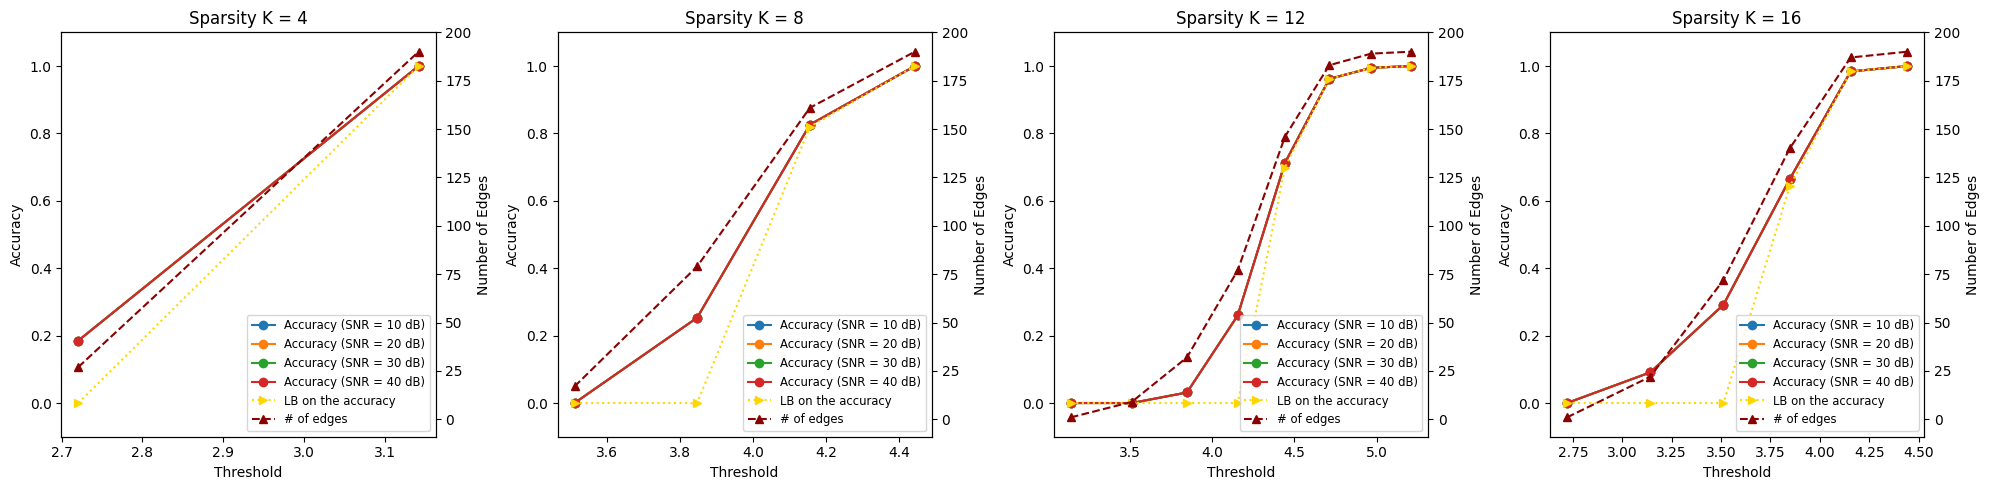

: 

In [24]:
# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Flatten the axs array for easier indexing in the loop
axs = axs.flatten()

# Create a separate list for the twin axes
axs_twin = []

# Initialize min and max values for accuracy, number of edges, and new curve
min_acc = 0  # Set min_acc to 0 as per your update
max_acc = 1  # Set max_acc to 1 as per your update
min_edges = float('inf')
max_edges = float('-inf')

# First loop to find the global min and max for number of edges
for j, K in enumerate(generating_sparsity):
    for SNR in noise_levels:
        edges_values = list(edges_number[K][SNR].values())
        min_edges = min(min_edges, min(edges_values))
        max_edges = max(max_edges, max(edges_values))

# Second loop for plotting
for j, K in enumerate(generating_sparsity):
    # Create the twin axis for each subplot
    axs_twin.append(axs[j].twinx())

    # Create a list to store legend handles and labels
    handles, labels = [], []

    for SNR in noise_levels:
        # Plotting accuracy on the primary y-axis with markers
        line, = axs[j].plot(list(accs[K][SNR].keys()), list(accs[K][SNR].values()), 
                            label=f'Acc SNR = {SNR} dB', marker='o')
        handles.append(line)
        labels.append(f'Accuracy (SNR = {SNR} dB)')

        # Compute and plot the additional curve: max(0, 2 - 190/E)
        threshold_list = list(edges_number[K][SNR].keys())
        edges_values = list(edges_number[K][SNR].values())
        new_curve = [max(0, 2 - 190 / E) for E in edges_values]

    # Plot this new curve on the left y-axis
    line, = axs[j].plot(threshold_list, new_curve, label="LB on the accuracy", linestyle=':', color='gold', marker='>')
    handles.append(line)
    labels.append("LB on the accuracy")

    # Plotting edge numbers on the twin y-axis with markers
    line, = axs_twin[j].plot(list(edges_number[K][SNR].keys()), list(edges_number[K][SNR].values()), 
                                label="# of edges", color='darkred', linestyle='--', marker='^')
    handles.append(line)
    labels.append("# of edges")

    # Set labels and title for each subplot
    axs[j].set_title(f'Sparsity K = {K}')
    axs[j].set_xlabel('Threshold')  # Replace with your actual x-axis label
    axs[j].set_ylabel('Accuracy')
    axs_twin[j].set_ylabel('Number of Edges')

    # Set the y-limits for accuracy and number of edges to be consistent
    axs[j].set_ylim(min_acc - 0.1, max_acc + 0.1)
    axs_twin[j].set_ylim(min_edges - 10, max_edges + 10)  # Adjust padding as needed

    # Merge legends
    axs[j].legend(handles, labels, loc='lower right', fontsize='small')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot after all plotting is done
plt.show()


In [3]:
d = 64
B = dct(np.eye(d), axis=0, norm='ortho').T

In [4]:
k = 30

In [5]:
def get_random_subsets(total_set, k, common_elements):
    # Step 1: Randomly choose `common_elements` elements for both U and V
    common = random.sample(total_set, common_elements)

    # Step 2: Choose remaining elements for U and V separately, ensuring no overlap
    remaining_u = random.sample(list(set(total_set) - set(common)), k - common_elements)
    remaining_v = random.sample(list(set(total_set) - set(common) - set(remaining_u)), k - common_elements)
    
    # Step 3: Construct the final subsets U and V
    U = common + remaining_u
    V = common + remaining_v

    
    return U, V

In [6]:
def generate_orthogonal_matrix(dim):
    """Generates a random orthogonal matrix of size (dim, dim)."""
    # Generate a random matrix
    A = np.random.randn(dim, dim)
    # Use QR decomposition to obtain an orthogonal matrix
    Q, _ = np.linalg.qr(A)
    return Q

In [7]:
def transform_subspaces(D_U, D_V):
    k, m = D_U.shape[1], D_V.shape[1]  # Number of atoms in subspaces

    # Generate random orthogonal transformations
    Q_U = generate_orthogonal_matrix(k)
    Q_V = generate_orthogonal_matrix(m)

    # Transform the subspaces
    transformed_D_U = D_U @ Q_U
    transformed_D_V = D_V @ Q_V

    # Ensure the transformed subspaces are orthonormal
    U_orth, _, _ = np.linalg.svd(transformed_D_U, full_matrices=False)
    V_orth, _, _ = np.linalg.svd(transformed_D_V, full_matrices=False)

    return U_orth, V_orth

In [6]:
import numpy as np

def k_SVD(A, K):
    # Perform Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(A, full_matrices=True)
    
    # Keep only the top K singular values and corresponding vectors
    U_k = U[:, :K]  # Top K left singular vectors
    S_k = np.diag(S[:K])  # Top K singular values (as a diagonal matrix)
    Vt_k = Vt[:K, :]  # Top K right singular vectors
    # Reconstruct the rank-K approximation of A
    A_k = U_k @ S_k @ Vt_k

    return A_k[0:K,0:K]

In [7]:
dist = {s:None for s in range(k)}
procr = {s:None for s in range(k)}

for s in tqdm(range(k+1)):
    U, V = get_random_subsets(list(range(d)), k, s)

    D_U = B[:,U]
    D_V = B[:,V]
    
    '''
    D_U = k_SVD(D_U, s)
    D_V = k_SVD(D_V, s)
    '''  
    # Computing Grassman distance
    _, S, _ = np.linalg.svd(D_U.T @ D_V)
    S = np.clip(S, -1.0, 1.0)
    m, l = D_U.shape[1], D_V.shape[1]
    dist[s] = np.linalg.norm(np.arccos(S[0:min([m,l])]))**2

    # Compute Procrustes solution allignment distance
    A_u, S_u, B_u = np.linalg.svd(D_U)
    A_v, S_v, B_v = np.linalg.svd(D_V)
    W, _, Z = np.linalg.svd(A_u.T @ A_v)

    F_u = W @ Z @ A_u.T
    F_v = A_v.T

    procr[s] = np.linalg.norm(F_u @ D_U - F_v @ D_V)**2

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:00<00:00, 118.51it/s]


Text(0.5, 0, 'Number of common atoms in shared dictionary')

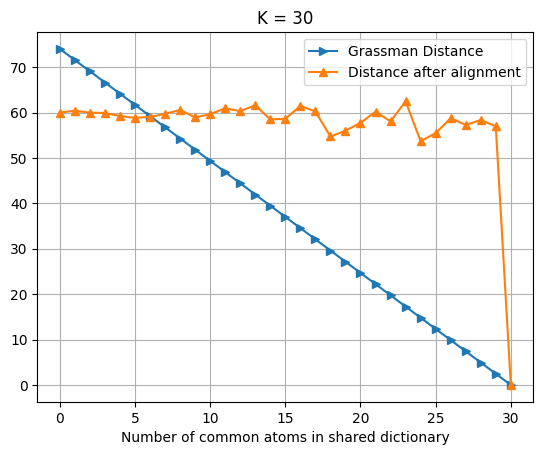

In [8]:
plt.plot(dist.values(), label='Grassman Distance', marker = '>')
plt.plot(procr.values(), label='Distance after alignment', marker='^')
plt.grid()
plt.legend()
plt.title('K = 30')
plt.xlabel('Number of common atoms in shared dictionary')